#1. Make neccesary imports and installs
To use the models and different plots and reports, we make the neccesary imports and insstall the libraries that are not installed by default

We also use a seed value which makes the code reproducable.

In [1]:
!pip install ydata-profiling
!pip install --upgrade ydata-profiling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV


np.random.seed(0)

#2. Import the data and do the initial analysis

We import the data and then convert it to a dataframe that can easily be used by python to perform different operations.

We use profile report which can be used to do some basic EDA on the data like checking missing values, duplicates, basic column statistics and correlations.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/project/train.csv")
df = df.drop('id', axis=1)

In [4]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("your_report.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:01<00:00, 15.32it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#3. Exploratory Data Analysis (EDA)
After seeing the initial analysis from profile report, we do some additional analysis on the data to get more information about the data we are dealing with.

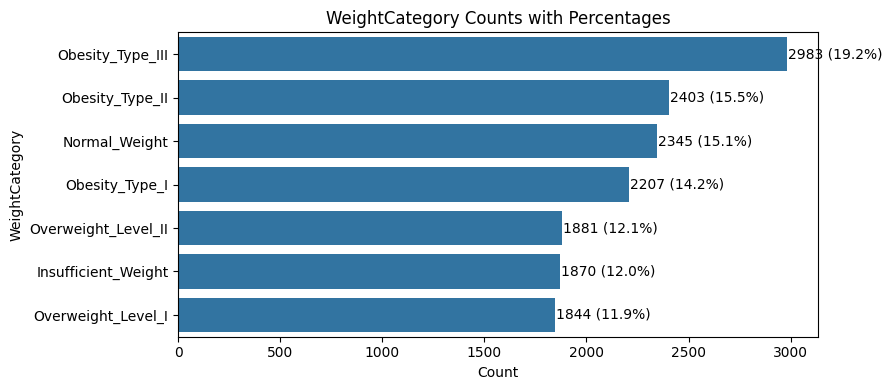

In [5]:
plt.figure(figsize=(9,4))
ax = sns.countplot(y='WeightCategory', data=df, order=df['WeightCategory'].value_counts().index)
total = len(df)
for p in ax.patches:
    count = int(p.get_width())
    pct = 100 * count / total
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2, f'{count} ({pct:.1f}%)',
            va='center')
ax.set_title('WeightCategory Counts with Percentages')
ax.set_xlabel('Count')
plt.tight_layout()
plt.show()


Above we checked if our prediction cloumn in the test dataset is balanced or not. While all the categories are not equally distributed, the distribution is not completely biased towards a particular class either.

Obesity_Type_III has a lot more entries and we need to take care about that while creating our training dataset.

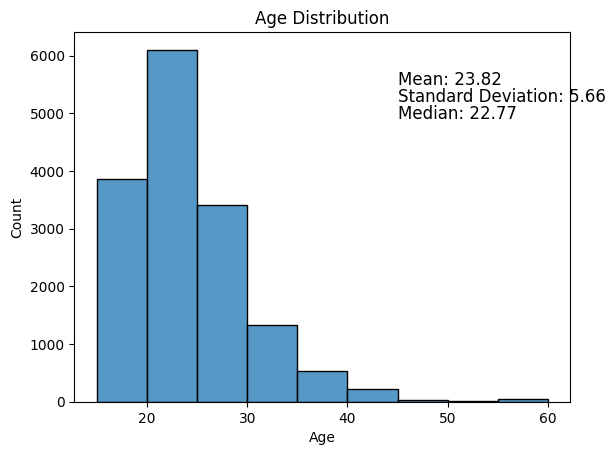

In [6]:
bin_edges = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
sns.histplot(df['Age'], bins=bin_edges, kde=False)
plt.title("Age Distribution")

mean_age = df['Age'].mean()
std_age = df['Age'].std()
median_age = df['Age'].median()

plt.text(45, 5500, f'Mean: {mean_age:.2f}', fontsize=12)
plt.text(45, 5200, f'Standard Deviation: {std_age:.2f}', fontsize=12)
plt.text(45, 4900, f'Median: {median_age:.2f}', fontsize=12)
plt.show()

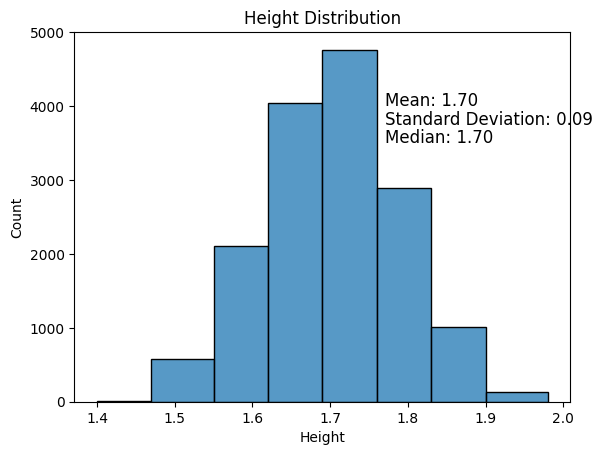

In [7]:
# Histogram for Height
bin_edges = [1.4, 1.47, 1.55, 1.62, 1.69, 1.76, 1.83, 1.9, 1.98]
sns.histplot(df['Height'],bins=bin_edges, kde=False)
plt.title("Height Distribution")

mean_height = df['Height'].mean()
std_height = df['Height'].std()
median_height = df['Height'].median()

plt.text(1.77, 4000, f'Mean: {mean_height:.2f}', fontsize=12)
plt.text(1.77, 3750, f'Standard Deviation: {std_height:.2f}', fontsize=12)
plt.text(1.77, 3500, f'Median: {median_height:.2f}', fontsize=12)
plt.show()

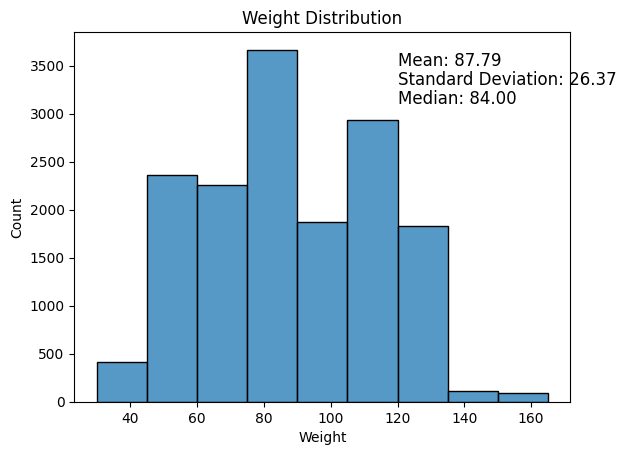

In [8]:
bin_edges = [30, 45, 60, 75, 90, 105, 120, 135, 150, 165]
sns.histplot(df['Weight'], bins=bin_edges, kde=False)
plt.title("Weight Distribution")

mean_weight = df['Weight'].mean()
std_weight = df['Weight'].std()
median_weight = df['Weight'].median()

plt.text(120, 3500, f'Mean: {mean_weight:.2f}', fontsize=12)
plt.text(120, 3300, f'Standard Deviation: {std_weight:.2f}', fontsize=12)
plt.text(120, 3100, f'Median: {median_weight:.2f}', fontsize=12)
plt.show()

We plot the columns age, height and weight and check the spread of the data in these columns. We use histogram with bins of equal intervals to easily make sense of which bin has more frequency.

The graph for age is an off-center bell curve with bias towards 20-30 years age group, whicch implies the dataset has more people in their 20s. The standard  deviation is also around 5 which is not that much considering the age range. So instead of using bins, we are better off giving this data in form of continous values since bins would create a bias.

Height column seems to be more of a traditional bell curve with the average around 1.7. The median is also 1.7 with standard deviation very low which means most people have their heights around mean. So this column does not seem to be a big differentiator.

The weight column is where it gets interesting. The bins form a pretty flattened bell curve with values having a lot less difference in frequencies between bins. The high standard deviation indicating a wider range and greater variability in weight among the individuals in the dataset. Let us compare it with the resultant weight category cloumn since both of them seems to have a similar split.

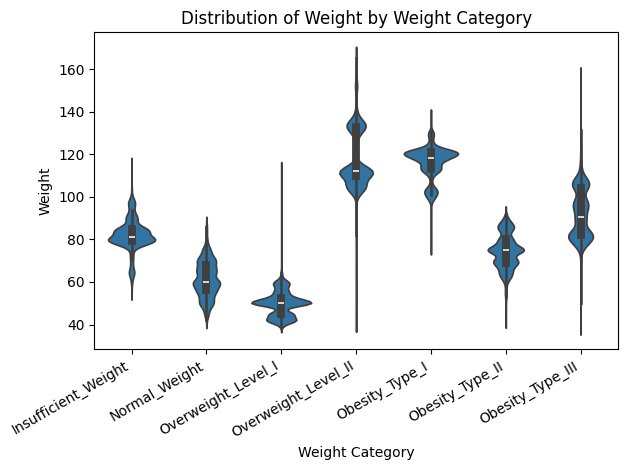

In [9]:
rev_map = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III'
}
sns.violinplot(x='WeightCategory', y='Weight', data=df)
plt.title('Distribution of Weight by Weight Category')
plt.xlabel('Weight Category')
plt.ylabel('Weight')
plt.xticks(ticks=list(rev_map.keys()), labels=list(rev_map.values()), rotation=30, ha='right')
plt.tight_layout()
plt.show()

The violin plot shows a relationship between weight and weight categories. With each weight category, the average weight seems to go higher with more datapoints around the average for each category.

Now let us try visualising how gender is affecting our data.

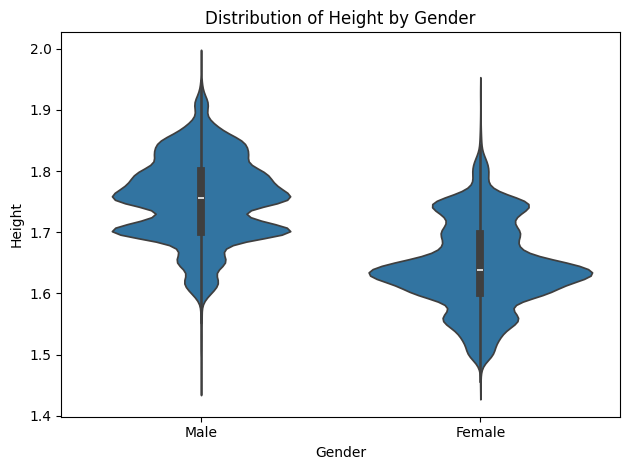

In [10]:
sns.violinplot(x='Gender', y='Height', data=df)
plt.title('Distribution of Height by Gender')
plt.xlabel('Gender')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

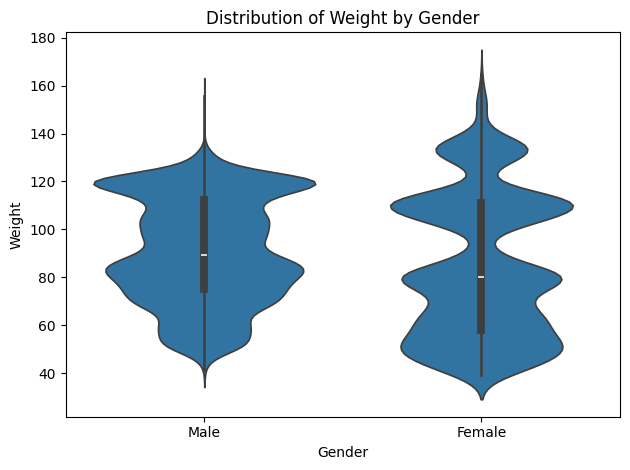

In [11]:
sns.violinplot(x='Gender', y='Weight', data=df)
plt.title('Distribution of Weight by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight')
plt.tight_layout()
plt.show()

We try to plot the graph for height and weight by gender. We can notice that the height is varying by gender as expected. Males in average have higher height than females and the shape of the violin suggests that the spread is around average as expected.

For weight we can see that while the average is pretty similar the data for the females have a lot of variatons and the data tends to skew in both the extremes in case of females. So we should try and do more analysis on relation between weights and the gender.

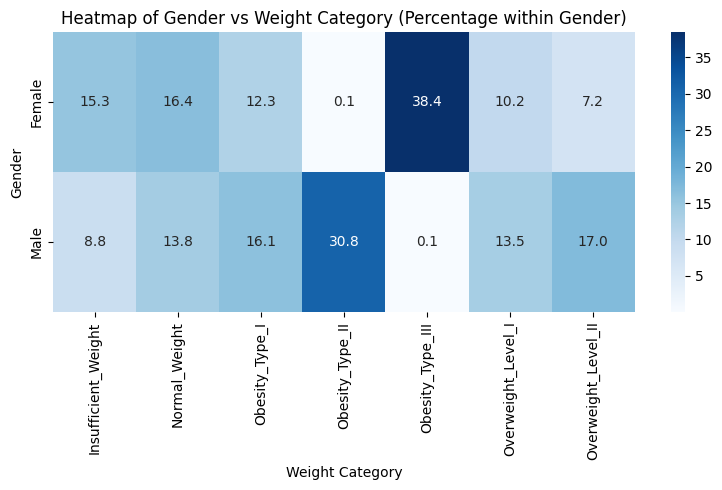

In [12]:
crosstab_family = pd.crosstab(df['Gender'], df['WeightCategory'])
crosstab_family = crosstab_family.rename(columns=rev_map)
crosstab_family_percentage = crosstab_family.div(crosstab_family.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 5))
sns.heatmap(crosstab_family_percentage, annot=True, fmt='.1f', cmap='Blues')

plt.title('Heatmap of Gender vs Weight Category (Percentage within Gender)')
plt.xlabel('Weight Category')
plt.ylabel('Gender')

plt.tight_layout()
plt.show()

From the heatmap we can see that in case of the female dataset, the dataset seems to skew more towards both the extremes. Females tend to have more insufficient weights in this dataset than men and a lot more obesity type 3 datapoints than males.

Males tend to be more type 2 obese and females tend to be more type 3 obese in this dataset. This would mean Gender would also be a good feature.

Now we go ahead and do analysis on more columns.

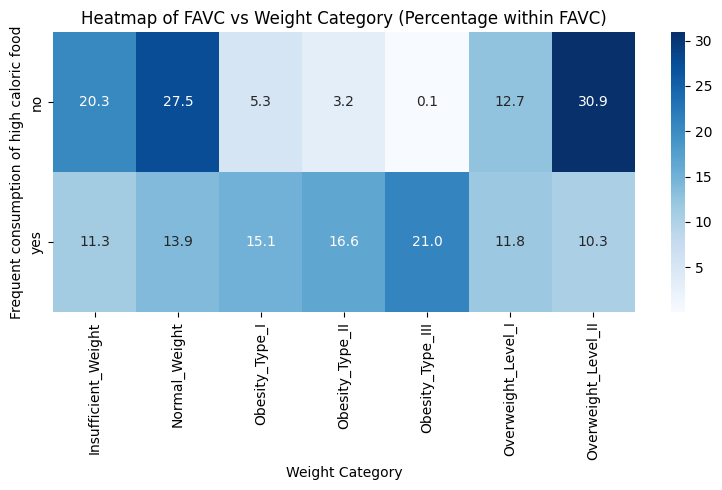

Unique value counts and percentages for FAVC:


Count  Percentage (%)
FAVC                       
yes   14184       91.315264
no     1349        8.684736

In [13]:
crosstab = pd.crosstab(df['FAVC'], df['WeightCategory'])
crosstab = crosstab.rename(columns=rev_map)
crosstab_percentage = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 5))
sns.heatmap(crosstab_percentage, annot=True, fmt='.1f', cmap='Blues')

plt.title('Heatmap of FAVC vs Weight Category (Percentage within FAVC)')
plt.xlabel('Weight Category')
plt.ylabel('Frequent consumption of high caloric food')

plt.tight_layout()
plt.show()

favc_counts = df['FAVC'].value_counts()
favc_percentages = df['FAVC'].value_counts(normalize=True) * 100
favc_summary = pd.DataFrame({'Count': favc_counts, 'Percentage (%)': favc_percentages})
print("Unique value counts and percentages for FAVC:")
display(favc_summary)

We can see that the FAVC column (Frequent consumption of high caloric food) is highly imbalanced, 91% of the rows have the value as yes.

But important thing to notice is that when the FAVC feature is no, then the weight category is rarely in the obese category. So while this column is imbalanced, it provides vital information that helps us separate between obese and not obese.

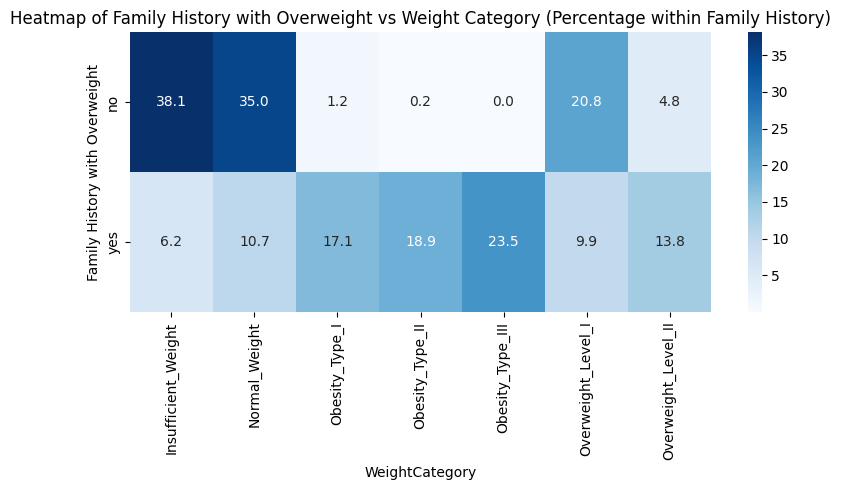

Unique value counts and percentages for Family History:


Count  Percentage (%)
family_history_with_overweight                       
yes                             12696        81.73566
no                               2837        18.26434

In [14]:
crosstab_family = pd.crosstab(df['family_history_with_overweight'], df['WeightCategory'])
crosstab_family = crosstab_family.rename(columns=rev_map)
crosstab_family_percentage = crosstab_family.div(crosstab_family.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 5))
sns.heatmap(crosstab_family_percentage, annot=True, fmt='.1f', cmap='Blues')

plt.title('Heatmap of Family History with Overweight vs Weight Category (Percentage within Family History)')
plt.ylabel('Family History with Overweight')

plt.tight_layout()
plt.show()

fh_counts = df['family_history_with_overweight'].value_counts()
fh_percentages = df['family_history_with_overweight'].value_counts(normalize=True) * 100
fh_summary = pd.DataFrame({'Count': fh_counts, 'Percentage (%)': fh_percentages})
print("Unique value counts and percentages for Family History:")
display(fh_summary)

Just like FAVC, family history column is also skewed but it also has a string correlation with weight category. People who lack family history about obesity, also happen to belong to mostly insufficient, normal and overweight category.

On the other hand people with family history of obesity tend to be obese themselves.

#4. Preparing data
Now we prepare the data by converting categorical columns to numerical columns and using standard scaler to scale down different columns so all of them belong to the same scale. Then we separate the data into features, output, train and test dataset and so on. We make a reusable function so that the same operations can also be done on the test dataset.

In [15]:
weight_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}
df['WeightCategory'] = df['WeightCategory'].map(weight_map)

In [16]:
print(df.shape)
df.columns

(15533, 17)


Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'WeightCategory'],
      dtype='object')

In [17]:
nutrition_features = df[['FCVC', 'CH2O', 'FAVC']]
nutrition_features['FAVC'] = nutrition_features['FAVC'].map({'yes': -1, 'no': 0})
scaler = StandardScaler()
nutrition_scaled = scaler.fit_transform(nutrition_features)
pca = PCA(n_components=1)
nutrition_score_pca = pca.fit_transform(nutrition_scaled)
print(pd.DataFrame({ 'Feature': ['FCVC', 'CH2O', 'FAVC_numeric'], 'Weight': pca.components_[0]}))

        Feature    Weight
0          FCVC  0.659168
1          CH2O  0.695757
2  FAVC_numeric -0.285340


/tmp/ipython-input-2669758093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nutrition_features['FAVC'] = nutrition_features['FAVC'].map({'yes': -1, 'no': 0})


Above we tried to find the best values to multiply the columns to create a combined health score using PCA.

In [18]:
def preprocess_data(df):

    #Creating Health score based on PCA weights
    df['HealthyEatingScore_PCA'] = df['FCVC']*0.659168 + df['CH2O']*0.695757 + df['FAVC'].map({'yes': -1, 'no': 0})*(-0.285340)


    #Creating X and y from the dataframe
    y = None
    if 'WeightCategory' in df.columns:
        y = df['WeightCategory']
        X = df.drop(columns=['WeightCategory'])
    else:
        X = df.copy()

    #Applying onehot encoders and standard scalers on
    categorical_features = ['Gender', 'MTRANS', 'FAVC', 'SCC', 'family_history_with_overweight', 'SMOKE']
    ordinal_features_caec = ['CAEC']
    ordinal_features_calc = ['CALC']
    numerical_features = ['Age', 'Height', 'Weight', 'HealthyEatingScore_PCA']
    remainder_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

    onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_categorical = onehot_encoder.fit_transform(X[categorical_features])
    categorical_feature_names = onehot_encoder.get_feature_names_out(categorical_features)

    ordinal_encoder_caec = OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently', 'Always']])
    X_ordinal_caec = ordinal_encoder_caec.fit_transform(X[ordinal_features_caec])
    ordinal_caec_feature_names = ordinal_encoder_caec.get_feature_names_out(ordinal_features_caec)

    ordinal_encoder_calc = OrdinalEncoder(categories=[['no', 'Sometimes', 'Frequently']])
    X_ordinal_calc = ordinal_encoder_calc.fit_transform(X[ordinal_features_calc])
    ordinal_calc_feature_names = ordinal_encoder_calc.get_feature_names_out(ordinal_features_calc)

    scaler = StandardScaler()
    X_numerical = scaler.fit_transform(X[numerical_features])
    numerical_feature_names = scaler.get_feature_names_out(numerical_features)

    X_remainder = X[remainder_features].values
    remainder_feature_names = remainder_features

    X_transformed = np.concatenate([X_categorical, X_ordinal_caec, X_ordinal_calc, X_numerical, X_remainder], axis=1)

    all_feature_names = np.concatenate([
        categorical_feature_names,
        ordinal_caec_feature_names,
        ordinal_calc_feature_names,
        numerical_feature_names,
        remainder_feature_names
    ])
    X = pd.DataFrame(X_transformed, columns=all_feature_names, index=X.index)

    return X, y

This function is basically transforming our data into X and y using scaling, encoding and adding the health score column. We made it into a function so that it could be reused on the traaining and the test dataset.

In [19]:
X, y = preprocess_data(df)

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0,stratify=y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(11649, 20) (3884, 20) (11649,) (3884,)


#5. Testing Different models

In [21]:
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [22]:
model_dt = dt.fit(X_train,y_train)
model_ada = ada.fit(X_train,y_train)
model_rf = rf.fit(X_train,y_train)
model_xgb = xgb.fit(X_train,y_train)

y_pred_dt = model_dt.predict(X_test)
y_pred_ada = model_ada.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)

print(accuracy_score(y_test,y_pred_dt))
print(accuracy_score(y_test,y_pred_ada))
print(accuracy_score(y_test,y_pred_rf))
print(accuracy_score(y_test,y_pred_xgb))

0.8493820803295572
0.6967044284243048
0.8954685890834192
0.9034500514933058


Here we run different classification models on the dataset and we see that XG Boost performs the best here.

In [23]:
parameters = {'gamma': [1.0935154163692284],'learning_rate':[0.016409147136248785],
              'max_depth':[7],'max_leaves': [31],
              'min_child_weight':[5],'n_estimators': [1032], 'reg_lambda': [2.25626558252889930],
              'reg_alpha': [0.02591342917807464], 'subsample': [0.7104552588600823],
              'colsample_bytree': [0.5719600338322923]
              }

These are the values we passed to GridsearchCV to test our model on. It had a lot of values but through a lot of trial and error we reached to these values in the end. We removed the other values as running this cell took a lot of time as the number of values was high.

In [24]:
xgb_tune = XGBClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator=xgb_tune, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)
best_model = grid_search.best_estimator_

0.903081799368662
{'colsample_bytree': 0.5719600338322923, 'gamma': 1.0935154163692284, 'learning_rate': 0.016409147136248785, 'max_depth': 7, 'max_leaves': 31, 'min_child_weight': 5, 'n_estimators': 1032, 'reg_alpha': 0.02591342917807464, 'reg_lambda': 2.2562655825288993, 'subsample': 0.7104552588600823}


In [25]:
y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9111740473738414

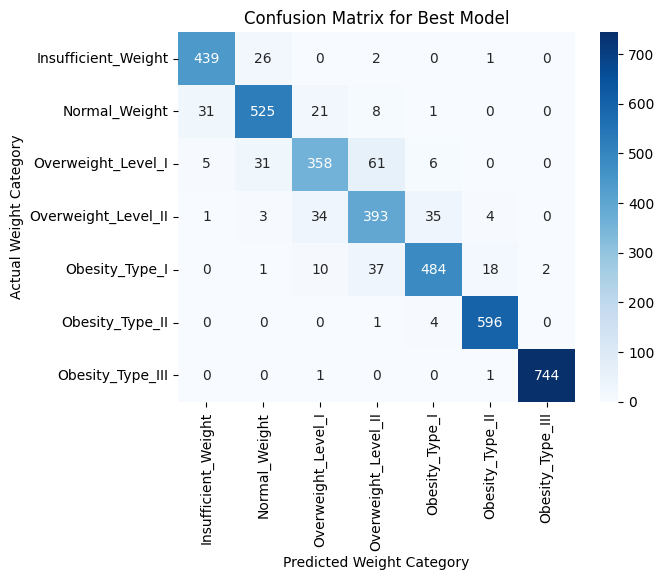

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(rev_map.values()), yticklabels=list(rev_map.values()))
plt.xlabel('Predicted Weight Category')
plt.ylabel('Actual Weight Category')
plt.title('Confusion Matrix for Best Model')
plt.show()

In [27]:
feat_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importances:")
feat_imp.head(15)

Feature Importances:


Weight                                0.176100
Gender_Male                           0.159128
FCVC                                  0.133294
family_history_with_overweight_yes    0.057278
TUE                                   0.046600
Age                                   0.045223
Height                                0.045146
CAEC                                  0.045125
FAVC_yes                              0.040599
HealthyEatingScore_PCA                0.039816
CH2O                                  0.038536
CALC                                  0.037557
NCP                                   0.033599
SCC_yes                               0.026892
MTRANS_Public_Transportation          0.026262
dtype: float32

#6. Running best model on test dataset


In [28]:
df_test = pd.read_csv("/content/drive/MyDrive/project/test.csv")
df_test_id = df_test['id']
df_test = df_test.drop(columns=['id'])
X_final, y_empty = preprocess_data(df_test)
y_final  = best_model.predict(X_final)

y_final = pd.DataFrame(y_final)
y_final = y_final[0].map(rev_map)

pd.concat([df_test_id,y_final],axis=1).to_csv("submission.csv",index=False)